In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
import warnings
warnings.filterwarnings('ignore')

In [3]:
race_type = '10K'
input_dir = '/home/freddy/insight/letsdothis/inputs/'
input_age   = race_type + '/age_map_' + race_type + '.csv'
input_times = race_type + '/avg_times_' + race_type + '.csv'
input_beta  = race_type + '/beta_' + race_type + '.csv'
input_gpx   = race_type + '/gpx_info_' + race_type + '.csv'
input_dist  = race_type + '/d_dist_' + race_type + '.csv'
input_evts  = race_type + '/event_title_list_' + race_type + '.csv'

In [3]:
def make_map(filename):
    df = pd.read_csv(filename, header=None)
    amap = {}
    for index, row in df.iterrows():
        amap[df.values[index][0]] = df.values[index][1]
    return amap

## Event List

In [51]:
evt_df =pd.read_csv(input_dir+input_evts)
#list(evt_df.event.values)

In [53]:
import csv
with open(input_dir+input_evts, 'r') as f:
    events = list(csv.reader(f))
print(events)

[['event'], ['Tilli 10K'], ['Greenwich Park Winter 10K Series'], ['Telford 10K'], ["Wye Valley Runners New Year's Day 10K"], ['Percy Pud 10K'], ['Skegness Coasters 10K'], ['Ribble Valley 10K'], ['RunThrough Chase The Moon Olympic Park 10K'], ["Wymondham AC New Year's Day 10K"], ['RunThrough Lee Valley VeloPark 10K'], ['Beith Harriers New Year Races'], ['Waterside 10K'], ['Seeley Cup 10K'], ['Royal Parks Winter 10K Series'], ['Self Transcendence 10K'], ['Woodcote 10K'], ["Mornington Chasers Regent's Park 10K Winter Series"], ['EHH Boxing Day 10K'], ['Andy Reading 10K'], ['Stoke Stampede 10K'], ["Serpentine New Year's Day 10K"], ['Bromham Pudding Run 10K'], ['Hoad Hill Harriers Christmas Pudding 10K'], ['Draycote Water Winter 10K Series'], ['Gravesend Santa Dash 5K / 10K'], ['3-1-5 Lancaster 5K / 10K Series'], ['QEOP Winter 10K Series'], ['Garstang 10K'], ['RunThrough Olympic Park 10K'], ['Ayrodynamic Turkey Trot 10K'], ['Stubbington Green 10K']]


## Age Map:

In [4]:
amap = make_map(input_dir+input_age)

In [5]:
MAX_AGE = -1
for key,val in amap.items():
    if val>MAX_AGE:
        MAX_AGE = val
print(MAX_AGE)

17


## Sex Map:

In [6]:
smap = {'W':1, 'M':2}

## Time Map:

In [7]:
df = pd.read_csv(input_dir+input_times)

In [8]:
def get_min_time(df,ID,sex,age):
    ''' Input: df, meeting ID, sex(either 1 or 2), age class
        Outut: If age_group is found, return the median time.
               Otherwise, find the closest age_group and return
               the corresponding median time
    '''
    temp=df[(df.meeting_id==ID) & (df.sex==sex)]
    Age = list(temp['age_group'].values)
    success = False
    if age in Age:
        age = age # Do nothing
        success = True
    else:
        Age.sort()
        success = False
        for i in Age:
            if i>age:
                age = i
                success=True
                break
        # Need to go backwards now
        if not success:
            for i in range(len(Age)-1,-1,-1):
                if Age[i] < age:
                    age = Age[i]
                    break
    #print(age,success)
    row = temp.loc[(temp['age_group']==age) & 
                   (temp['sex']==sex) &
                   (temp['meeting_id'] == ID)]
    return (row.min_time).item()        

## Beta Map:

In [9]:
# Just re-use the age function
beta_map = make_map(input_dir+input_beta)

## GPX Map:

In [10]:
gpx_df = pd.read_csv(input_dir+input_gpx)

In [11]:
gpx_df.head()

,meeting_id,sum_up,sigma,diff
0,223524,7.967742,0.403710,-2.1
1,223537,19.370968,0.412258,0.6
2,223538,16.483871,0.509677,1.7
3,232067,3.967742,0.075323,-0.2
4,236203,5.112903,0.348548,-0.6


In [12]:
# Make maps:
ID_sum_up = dict(zip(gpx_df.meeting_id, gpx_df.sum_up))
ID_diff   = dict(zip(gpx_df.meeting_id, gpx_df['diff']))
ID_sigma  = dict(zip(gpx_df.meeting_id, gpx_df.sigma))

In [13]:
def calc_betax(ID, sexstr, agestr):
    # Elevation stuff:
    age    = amap[agestr]
    sex    = smap[sexstr]
    time   = get_min_time(df,ID,sex,age)
    sum_up = ID_sum_up[ID]
    sigma  = ID_sigma[ID]
    diff   = ID_diff[ID]
    x = [age,sex,time,sum_up,sigma,diff]
    b = [beta_map['age_group'], beta_map['sex'],beta_map['min_time'],
         beta_map['sum_up'],beta_map['sigma'],beta_map['diff']]
    betax = 0.0
    for idx, val in enumerate(x):
        betax += x[idx]*b[idx]
    return betax

In [14]:
d = calc_betax(223524,'M','V35')

In [15]:
df.head()

,meeting_id,sex,age_group,race_title,min_time
0,223524,2,6,10K,48.066667
1,223524,2,5,10K,34.433333
2,223524,2,7,10K,49.850000
3,223524,2,8,10K,49.433333
4,223524,2,9,10K,45.666667


In [16]:
df_d = pd.read_csv(input_dir+input_dist)

In [17]:
df_d.head()

,bin,xval,yval,dx
0,0,10.22699,0.00000,0.17952
1,1,10.40651,0.00013,0.17952
2,2,10.58603,0.00032,0.17952
3,3,10.76555,0.00077,0.17952
4,4,10.94507,0.00115,0.17952


In [18]:
bins, xs, ys, dxs = [], [], [], []
for index,row in df_d.iterrows():
    bins.append(row.bin)
    xs.append(row.xval)
    ys.append(row.yval)
    dxs.append(row.dx)

In [19]:
def get_score(dval):
    score = -1.0
    for idx,val in enumerate(xs):
        dx = dxs[idx]*0.5
        dlo = xs[idx] - dx
        dhi = xs[idx] + dx
        if dval >= dlo and dval < dhi:
            score = ys[idx]
            break
    return score

In [20]:
print('score = %1.1f, b.x = %1.2f' % (get_score(d)*10,d))

score = 6.9, b.x = 18.75


In [21]:
scores = []
for key,val in ID_sigma.items():
    d = calc_betax(key,'M','SEN')
    score = get_score(d)*10.0
    scores.append(score)
    #print('score = %1.1f, b.x = %1.2f' % (score,d))

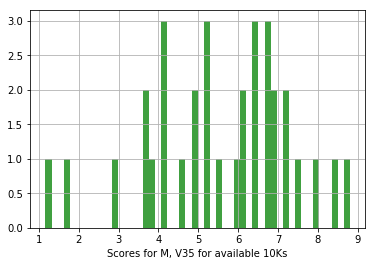

In [22]:
n, bins, patches = plt.hist(scores, 50, density=False, 
                            facecolor='g', alpha=0.75)
#plt.axis([10, 35, 0.0, 0.175])
plt.grid(True)
plt.xlabel('Scores for M, V35 for available 10Ks')
plt.show()

In [23]:
print(get_score(calc_betax(223537,'M','SEN')))
print(get_score(calc_betax(223538,'M','SEN')))
print(get_score(calc_betax(271791,'M','SEN')))
print(get_score(calc_betax(271807,'M','SEN')))

0.7138
0.68958
0.68958
0.64396


In [5]:
gpx_df = pd.read_csv(input_dir+input_gpx)
id_sum_up = dict(zip(gpx_df.meeting_id, gpx_df.sum_up))
id_diff   = dict(zip(gpx_df.meeting_id, gpx_df['diff']))
id_sigma  = dict(zip(gpx_df.meeting_id, gpx_df.sigma))
sum_up = id_sum_up[223524]